In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')


C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\1317286376.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2021_Green_Taxi_Trip_Data.csv')


In [64]:



irrelevant_columns = ['RatecodeID', 'store_and_fwd_flag', 'improvement_surcharge',
                     'ehail_fee', 'mta_tax', 'extra', 'fare_amount',
                     'congestion_surcharge']
df = df.drop(irrelevant_columns, axis=1)
df.info()
df=df.drop_duplicates()
df = df[(df.trip_distance >= 0) & (df.tip_amount >= 0) & (df.tolls_amount >= 0) & (df.total_amount >= 0)]
df['payment_type'] = df['payment_type'].astype(object)
df['trip_type'] = df['trip_type'].astype(object)




df.loc[(df['tip_amount'] > 0) & (df['payment_type'].isnull()), 'payment_type'] = 1
df.loc[df['passenger_count'] > 4, 'payment_type'] = 6
df.loc[df['passenger_count'] > 4, 'trip_type'] = 3




df['pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df = df[df['pickup_datetime'].dt.year == 2021]


df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['weekday'] = df['pickup_datetime'].dt.day_name()
weekday_mapping = {
   'Monday': 1,
   'Tuesday': 2,
   'Wednesday': 3,
   'Thursday': 4,
   'Friday': 5,
   'Saturday': 6,
   'Sunday': 7
}
# Apply the mapping to the 'weekday' column
df['weekday'] = df['weekday'].map(weekday_mapping)




df['dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.day
df['dropoff_month'] = df['dropoff_datetime'].dt.month
# Create the empty_vendor_trips DataFrame 






df.drop(columns=['lpep_pickup_datetime', 'lpep_dropoff_datetime'], inplace=True)
borough_df = pd.read_csv('Boroughs.csv')
df = df.merge(borough_df[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'PU_Borough'}, inplace=True)


df = df.merge(borough_df[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
df.rename(columns={'Borough': 'DO_Borough'}, inplace=True)
df = pd.get_dummies(df, columns=['PU_Borough','DO_Borough'], prefix=['PU','DO'], drop_first=True)
df['pickup_date'] = df['pickup_month'].astype(str) + '-' + df['pickup_day'].astype(str)
empty_vendor_trips = df[df['VendorID'].isnull()].groupby(['pickup_date', 'LocationID_x', 'LocationID_y']).size().groupby(level=[1, 2]).mean().unstack(fill_value=0) 


# empty_vendor_trips = df[df['VendorID'].isnull()].groupby(['pickup_date', 'LocationID_x', 'LocationID_y']).size().unstack(fill_value=0) 


# print('empty:',empty_vendor_trips)
df.dropna(subset=['VendorID'], inplace=True)
df.drop([ 'PULocationID', 'DOLocationID', 'pickup_datetime', 'dropoff_datetime' ,'pickup_date'], axis=1, inplace=True)
print(df.columns)
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)
df = df.apply(pd.to_numeric, errors='coerce')
for column in df.columns:
   null_percentage = df[column].isnull().mean()
   if 0.05 < null_percentage <= 0.3:
       missing_rows = df[df[column].isnull()]
       complete_rows = df[df[column].notnull()]


       features_to_drop = [column]
       if complete_rows[column].dtype in ['int64', 'float64']:
           model = HistGradientBoostingRegressor()
           model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
           predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
           df.loc[df[column].isnull(), column] = predicted_values




       else:
           model = HistGradientBoostingClassifier()
           model.fit(complete_rows.drop(columns=features_to_drop, errors='ignore'), complete_rows[column])
           predicted_values = model.predict(missing_rows.drop(columns=features_to_drop, errors='ignore'))
           df.loc[df[column].isnull(), column] = predicted_values


print(df.LocationID_x.head())
print(df.LocationID_y.head())
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
print(missing_value_df)

df['PU_Bronx'] = (df.filter(like='PU_').sum(axis=1) == 0).astype(int)

df['DO_Bronx'] = (df.filter(like='DO_').sum(axis=1) == 0).astype(int)
# Create OD matrix
od_matrix = pd.DataFrame(index=df.columns[df.columns.str.startswith('PU_')],
                         columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)
for pu_col in df.columns[df.columns.str.startswith('PU_')]:
    for do_col in df.columns[df.columns.str.startswith('DO_')]:
        od_matrix.loc[pu_col, do_col] = df[(df[pu_col] == 1) & (df[do_col] == 1)].shape[0]

# Calculate sums for origins and destinations
od_matrix.loc['Total'] = od_matrix.sum()  # Sum for each drop-off column
od_matrix['Total'] = od_matrix.sum(axis=1)  # Sum for each pickup row


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068755 entries, 0 to 1068754
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   VendorID               819640 non-null   float64
 1   lpep_pickup_datetime   1068755 non-null  object 
 2   lpep_dropoff_datetime  1068755 non-null  object 
 3   PULocationID           1068755 non-null  int64  
 4   DOLocationID           1068755 non-null  int64  
 5   passenger_count        656321 non-null   float64
 6   trip_distance          1068755 non-null  float64
 7   tip_amount             1068755 non-null  float64
 8   tolls_amount           1068755 non-null  float64
 9   total_amount           1068755 non-null  float64
 10  payment_type           656321 non-null   float64
 11  trip_type              656321 non-null   float64
dtypes: float64(8), int64(2), object(2)
memory usage: 97.8+ MB
Index(['VendorID', 'passenger_count', 'trip_distance', 'tip_amount',

C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\162858737.py:114: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)


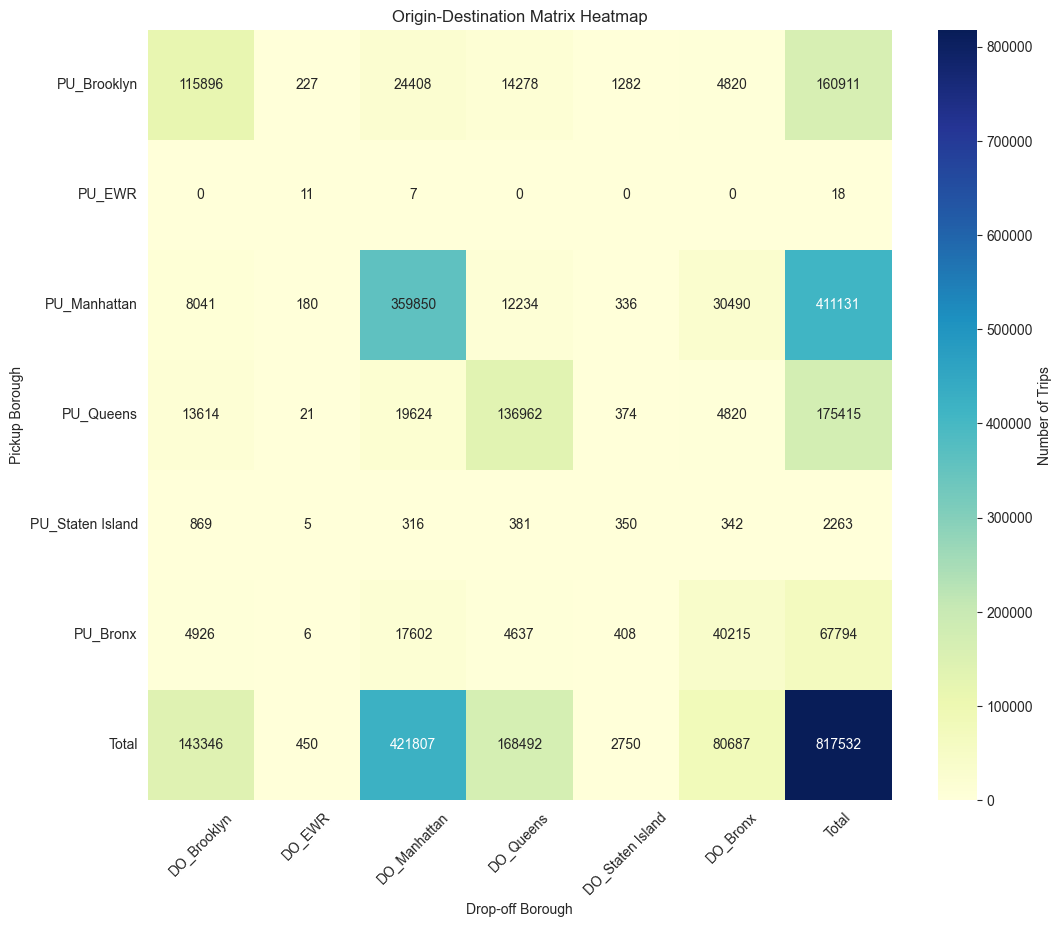

In [65]:
# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={"label": "Number of Trips"})
plt.title("Origin-Destination Matrix Heatmap")
plt.xlabel("Drop-off Borough")
plt.ylabel("Pickup Borough")
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


In [66]:
od_matrix = pd.DataFrame(index=df.columns[df.columns.str.startswith('PU_')],  
                         columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)  
for pu_col in df.columns[df.columns.str.startswith('PU_')]:  
    for do_col in df.columns[df.columns.str.startswith('DO_')]:  
        od_matrix.loc[pu_col, do_col] = df[(df[pu_col] == 1) & (df[do_col] == 1)].shape[0]  

# محاسبه مجموع کل سفرها  
total_trips = od_matrix.sum().sum()  # مجموع تمامی سفرها در ماتریس  

# محاسبه درصد سفرها در ماتریس  
od_matrix_percent = od_matrix.copy()  
for pu_col in od_matrix_percent.index:  
    for do_col in od_matrix_percent.columns:  
        if od_matrix_percent.loc[pu_col, do_col] > 0:  
            percent = (od_matrix_percent.loc[pu_col, do_col] / total_trips) * 100  
            od_matrix_percent.loc[pu_col, do_col] = percent  
        else:  
            od_matrix_percent.loc[pu_col, do_col] = 0  
# دیکشنری برای نگه‌داری ارتباط بین نام بوره‌ها و شناسه‌هایشان  
borough_ids = {  
    'Bronx': 1,  
    'Brooklyn': 2,  
    'Manhattan': 3,  
    'Queens': 4,  
    'Staten Island': 5  
}  

# ایجاد یک دیکشنری برای جمع‌آوری اطلاعات  
result = []  
for pu_col in od_matrix_percent.index:  
    for do_col in od_matrix_percent.columns:  
        percent = od_matrix_percent.loc[pu_col, do_col]  
        count = od_matrix.loc[pu_col, do_col]  # تعداد سفرها از ماتریس اصلی  
        if percent > 0:  # تنها جفت‌های مثبت  
            pickup_borough = pu_col.split('_')[-1]  # نام بوره  
            dropoff_borough = do_col.split('_')[-1]  # نام بوره  
            
            # ذخیره تمام مقادیر در نتیجه بدون اعمال شرط
            result.append({  
                'Pickup': pickup_borough,  
                'Dropoff': dropoff_borough,  
                'Percentage': percent,  
                'Trip Count': count  # استفاده از دیکشنری برای شناسه  
            })  

# تبدیل به DataFrame
result_df = pd.DataFrame(result)  

# اعمال شرط در سطح DataFrame: فیلتر کردن بخش‌هایی که مبدا و مقصد یکی هستند
result_diff = result_df[result_df['Pickup'] != result_df['Dropoff']]
result_diff = result_diff.sort_values(by='Percentage', ascending=False)  
result_diff.columns = ['Pickup Borough', 'Dropoff Borough', 'Percentage of Trips', 'Number of Trips']  
print("Ranking City Blocks by the Highest Percentage of Inter-Block Trips")
result_diff.index = np.arange(1, len(result_diff)+1)
print(result_diff.head(10))

result_same = result_df[result_df['Pickup'] == result_df['Dropoff']]
result_same = result_same.sort_values(by='Percentage', ascending=False)  
result_same.columns = ['Pickup Borough', 'Dropoff Borough', 'Percentage of Trips', 'Number of Trips']  
print("\n Ranking City Blocks by the Highest Percentage of Intra-Block Trips")
result_same.index = np.arange(1, len(result_same)+1)
print(result_same.head(5))

C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\2695917170.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  columns=df.columns[df.columns.str.startswith('DO_')]).fillna(0)


Ranking City Blocks by the Highest Percentage of Inter-Block Trips
   Pickup Borough Dropoff Borough  Percentage of Trips  Number of Trips
1       Manhattan           Bronx             3.729518            30490
2        Brooklyn       Manhattan             2.985571            24408
3          Queens       Manhattan             2.400395            19624
4           Bronx       Manhattan             2.153066            17602
5        Brooklyn          Queens             1.746476            14278
6          Queens        Brooklyn             1.665256            13614
7       Manhattan          Queens             1.496455            12234
8       Manhattan        Brooklyn             0.983570             8041
9           Bronx        Brooklyn             0.602545             4926
10       Brooklyn           Bronx             0.589579             4820

 Ranking City Blocks by the Highest Percentage of Intra-Block Trips
  Pickup Borough Dropoff Borough  Percentage of Trips  Number of Trips
1

C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\2695917170.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '14.176325819662106' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  od_matrix_percent.loc[pu_col, do_col] = percent
C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\2695917170.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.027766497213564726' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  od_matrix_percent.loc[pu_col, do_col] = percent
C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\2695917170.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.985571206998625' has dtype incompatible with int64, please explicitly cast to a

The OD matrix is balanced.


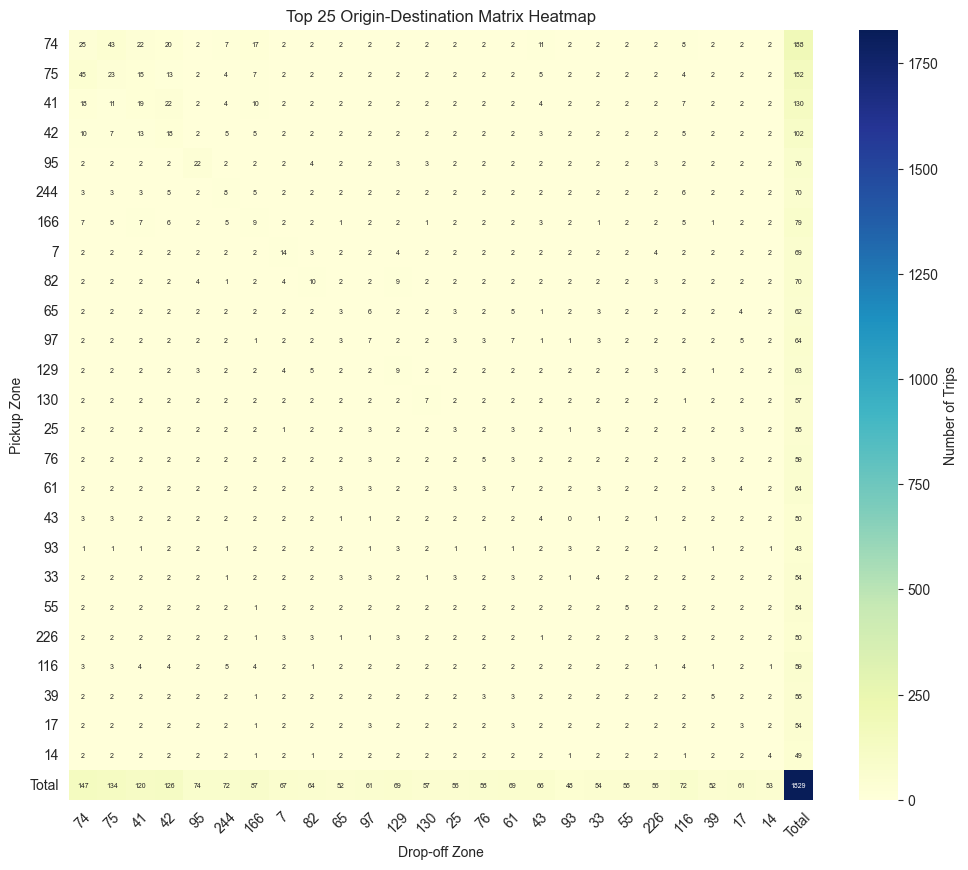

In [67]:
df['pickup_date'] = df['pickup_month'].astype(str) + '-' + df['pickup_day'].astype(str) 


# Step 2: Group by the new pickup_date and the location IDs 
od_matrix = df.groupby(['pickup_date', 'LocationID_x', 'LocationID_y']).size().groupby(level=[1, 2]).mean().unstack(fill_value=0) 
# print(empty_vendor_trips.index.names)
# print(od_matrix.index.names)
# Print the OD matrix to check 
# print(od_matrix)
# Get the top 25 zones based on total trips
top_zones = od_matrix.sum(axis=1).nlargest(25).index
# print(top_zones)
filtered_od_matrix = od_matrix.loc[top_zones, top_zones]
# print('filtered:',filtered_od_matrix)
# print(empty_vendor_trips.index)
empty_vendor_trips = empty_vendor_trips.loc[top_zones,top_zones]
# print('empty:',empty_vendor_trips)


filtered_od_matrix = empty_vendor_trips+ filtered_od_matrix
# print(filtered_od_matrix)


filtered_od_matrix.loc['Total'] = filtered_od_matrix.sum()  # Sum for each drop-off column
filtered_od_matrix['Total'] = filtered_od_matrix.sum(axis=1)


#print(filtered_od_matrix.info)
#print(filtered_od_matrix['Total'])
#print(filtered_od_matrix.T['Total'])
if filtered_od_matrix['Total'].sum() == filtered_od_matrix.T['Total'].sum():
   print("The OD matrix is balanced.")
else:
   print("The OD matrix is not balanced.")
# Plotting the heatmap for the filtered OD matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_od_matrix, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={"label": "Number of Trips"},annot_kws={"size": 5})
plt.title("Top 25 Origin-Destination Matrix Heatmap")
plt.xlabel("Drop-off Zone")
plt.ylabel("Pickup Zone")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [68]:
# ساخت ماتریس خالی برای میانگین هزینه‌ها
cost_matrix = pd.DataFrame(index=top_zones, columns=top_zones).fillna(0)

# پر کردن ماتریس با میانگین هزینه برای هر جفت مبدا و مقصد
for pickup_zone in top_zones:
    for dropoff_zone in top_zones:
        # فیلتر کردن داده‌ها برای زون‌های مبدا و مقصد خاص
        filtered_data = df[(df['LocationID_x'] == pickup_zone) & (df['LocationID_y'] == dropoff_zone)]
        
        # محاسبه میانگین هزینه
        if not filtered_data.empty:
            avg_cost = filtered_data['total_amount'].mean()
        else:
            avg_cost = 0  # اگر داده‌ای وجود نداشت، مقدار صفر قرار داده می‌شود
        
        # پر کردن ماتریس با مقدار میانگین هزینه
        cost_matrix.loc[pickup_zone, dropoff_zone] = avg_cost

# نمایش ماتریس میانگین هزینه
print(cost_matrix)

# # رسم نمودار Heatmap برای ماتریس میانگین هزینه
# plt.figure(figsize=(12, 10))
# sns.heatmap(cost_matrix.astype(float), cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={"label": "Average Cost"}, annot_kws={"size": 7})
# plt.title("Average Cost Matrix for Top Zones")
# plt.xlabel("Drop-off Zone")
# plt.ylabel("Pickup Zone")
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.show()


C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\2054021642.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cost_matrix = pd.DataFrame(index=top_zones, columns=top_zones).fillna(0)
C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\2054021642.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.596322628095121' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cost_matrix.loc[pickup_zone, dropoff_zone] = avg_cost
C:\Users\frequensy\AppData\Local\Temp\ipykernel_13260\2054021642.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.808243495663776' has dty

LocationID_x        74         75         41         42         95   \
LocationID_x                                                          
74             8.596323   9.808243   8.711648  10.094008  41.665789   
75             8.735162   7.914903   9.416134  12.905925  46.539174   
41             8.877126  10.057107   7.510398   8.804636  53.926190   
42            10.552005  13.962500   8.785787   8.190446  49.310000   
95            47.529444  51.593590  54.739524  42.255455  10.038044   
244           18.291258  24.135521  16.586909  13.303624  56.062500   
166           12.196973  13.086305   8.878820  11.181001  45.594545   
7             28.163239  28.520370  33.272973  31.666364  28.645693   
82            35.758077  34.931818  44.805000  32.116875  14.419023   
65            40.778182  39.351071  44.905455  43.997778  35.882381   
97            46.752778  42.341290  47.600714  48.752105  38.416471   
129           31.632692  33.065500  38.646364  33.289000  20.457405   
130   

In [69]:
#gravity
def gravity_model(origin, destination, cost_matrix, impedance_func):
    # Calculate impedance factors for the cost matrix
    impedance_matrix = impedance_func(cost_matrix)
    
    # Initialize the flow matrix
    num_zones = len(origin)
    flow_matrix = np.zeros((num_zones, num_zones))
    
    # Compute the flow using the gravity model formula
    for i in range(num_zones):
        for j in range(num_zones):
            if i != j:  # Skip diagonal elements if trips within the same zone aren't allowed
                flow_matrix[i, j] = origin[i] * destination[j] * impedance_matrix[i, j]
        
        # Normalize flows to ensure row sums match origin totals
        total_flows = np.sum(flow_matrix[i, :])
        if total_flows > 0:
            flow_matrix[i, :] *= origin[i] / total_flows
    
    return flow_matrix

# Example of impedance function: exponential decay
def exponential_impedance(cost_matrix, beta=0.1):
    return np.exp(-beta * cost_matrix)

filtered_od_matrix = filtered_od_matrix.drop(index='Total', columns='Total')
origin = filtered_od_matrix.sum(axis=1).to_numpy()
destination = filtered_od_matrix.sum(axis=0).to_numpy()
cost_matrix_np = cost_matrix.to_numpy()
print(f"origin length: {len(origin)}")
print(f"destination length: {len(destination)}")
print(f"cost_matrix shape: {cost_matrix_np.shape}")

flow_matrix = gravity_model(
    origin ,  # مجموع سفرها از هر منطقه
    destination,  # مجموع سفرها به هر منطقه
    cost_matrix=cost_matrix_np,
    impedance_func=exponential_impedance
)

print("Flow Matrix:")
print(flow_matrix)

origin length: 25
destination length: 25
cost_matrix shape: (25, 25)
Flow Matrix:
[[0.00000000e+00 3.92938828e+01 3.93232224e+01 3.59643451e+01
  9.01943050e-01 9.13230316e+00 2.10649827e+01 3.48294950e+00
  1.45136955e+00 5.58379006e-01 4.05436584e-01 2.61698749e+00
  1.87300066e-01 3.47601717e-01 1.26979376e-01 3.89739720e-01
  1.53092658e+01 5.56963923e-01 5.96305458e-01 1.97737822e-02
  1.50723961e+00 1.41432003e+01 1.56307504e-01 2.43446261e-01
  1.66943069e-01]
 [4.15171287e+01 0.00000000e+00 3.16112056e+01 2.34174473e+01
  4.77879160e-01 5.27088565e+00 1.68684153e+01 2.42625365e+00
  1.08798119e+00 7.51396108e-01 7.93232862e-01 1.37328957e+00
  9.16810590e-02 4.80150616e-01 1.21321741e-01 3.19353099e-01
  1.36983926e+01 1.78374401e-01 6.30487734e-01 3.17578057e-02
  1.57465749e+00 8.75390773e+00 4.03301616e-02 5.79251571e-01
  5.76317548e-02]
 [2.96495768e+01 2.39475402e+01 0.00000000e+00 2.55630608e+01
  1.65371495e-01 7.11142506e+00 1.78254484e+01 1.51876892e+00
  6.22892922e-